# Лабораторная работа 2. Решающие деревья и случайные леса.

ФИО: Николаев Сергей Владимирович

Группа: 317

In [1]:
import numpy as np

In [2]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [3]:
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.cross_validation import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.base import BaseEstimator

### I. Решающие деревья своими руками
#### Задача 1.
В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__1__

Реализуйте следующую функцию:

In [4]:
def find_best_split(feature_vector, target_vector):    
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    
    R = feature_vector.shape[0]
    
    uniq_values, counts = np.unique(feature_vector, return_counts=True)
    if uniq_values.shape[0] < 2:
        # нет уникальных значений в векторе признаков
        return (None, None, None, -10.0)
    thresholds = (uniq_values[:-1] + uniq_values[1:]) / 2
    
    Rl = np.cumsum(counts[:-1])
    Rr = R - Rl
    successes = np.sum(target_vector)
    successes_l = np.cumsum(np.sum(target_vector * (feature_vector == uniq_values[:, np.newaxis]), axis=1)[:-1])
    successes_r = successes - successes_l
    
    # 1 - p ** 2 - (1 - p) ** 2 = 2 * p * (1 - p)
    # после несложных преобразований получим:
    ginis = (-2 / R) * (successes - successes_l ** 2 / Rl - successes_r ** 2 / Rr)
    best_ind = np.argmax(ginis)
    
    return thresholds, ginis, thresholds[best_ind], ginis[best_ind]

Параметры:
* feature_vector: вещественнозначный вектор значений признака (np.array)
* target_vector: вектор классов объектов (np.array). len(feature_vector)==len(target_vector).

Возвращаемые значения:
* thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно разделить на две различные подвыборки, или поддерева (np.array)
* ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds. (np.array, len(ginis)==len(thresholds))
* оптимальный порог (число)
* оптимальное значение критерия Джини (число)

Под критерием Джини здесь подразумевается следующая функция:
$$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r),$$
$R$ - множество объектов, $R_l$ и $R_r$ - объекты, попавшие в левое и правое поддерево, $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ - доля объектов класса 1 и 0 соответственно.

Указания:
* Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
* За наличие в функции циклов балл будет снижен. Векторизуйте! :)

__2__
Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах,а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог - значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака - класс" для всех пяти признаков.

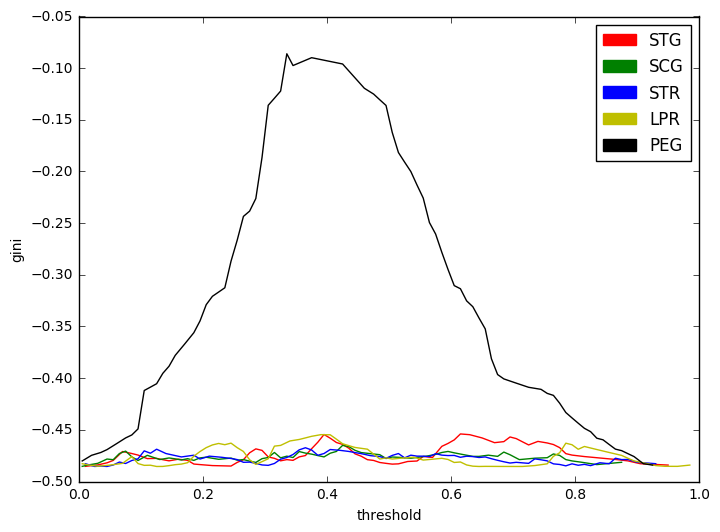

In [5]:
students = pd.read_csv('students.csv')
cols = students.columns

plt.figure(figsize=(8, 6))
patches = []
for col, color in zip(cols, ['r', 'g', 'b', 'y', 'k']):
    if col == ' UNS':
        continue
    thresholds, ginis, best_t, best_g = find_best_split(students[col].values, students[' UNS'].values)
    plt.plot(thresholds, ginis, c=color)
    patches.append(mpatches.Patch(color=color, label=col))

plt.legend(handles=patches, loc=0)
plt.xlabel('threshold')
plt.ylabel('gini')
plt.show()

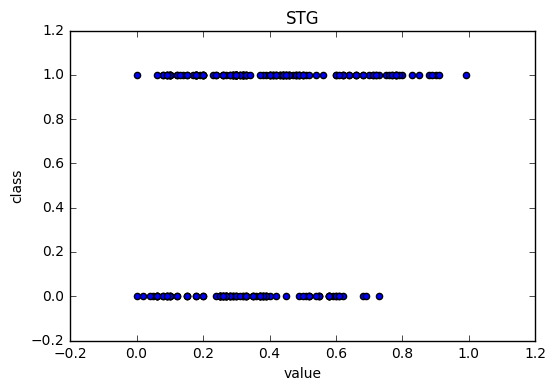

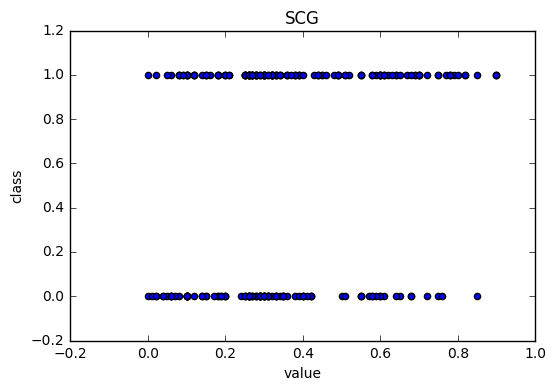

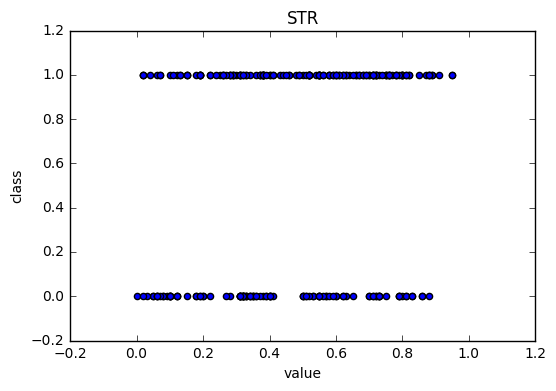

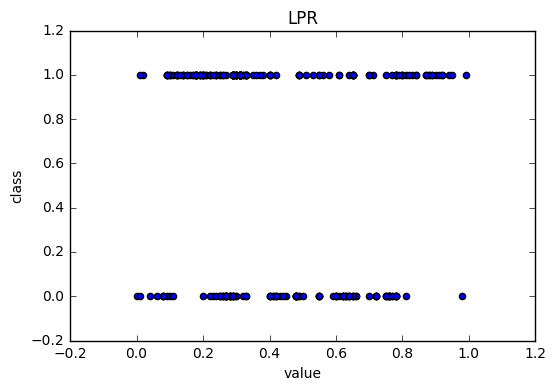

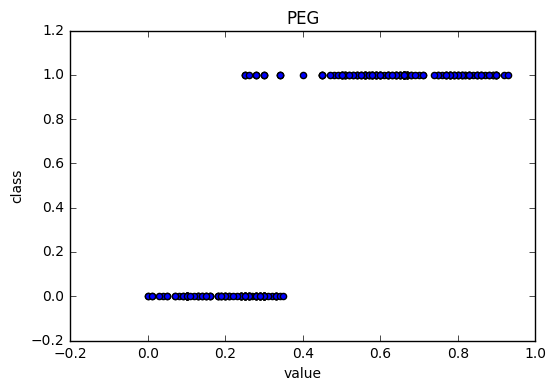

In [6]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
for col in cols:
    if col == ' UNS':
        continue
    plt.title(col)
    plt.xlabel('value')
    plt.ylabel('class')
    plt.scatter(students[col].values, students[' UNS'].values)
    plt.show()

__3__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

(・・ ) ?
Производить деление выборки на два поддерева следует по признаку PEG. Это действительно согласуется с визуальной оценкой scatter-графиков. Кривые для "хороших" признаков должны иметь ярко выраженный пик. Значения критерия Джини для "плохих" признаков практически не зависят от порога, что говорит о равномерности распределения целевой переменной по этим признакам. 

__4__

Реализуйте класс для обучения решающих деревьев. Мы не будем усложнять класс множеством параметров, как в sklearn. Требования к классу:
* Единственный параметр дерева - вектор, задающий типы признаков: если в позиции i стоит 0, то с признаком номер i нужно работать как с вещественным, если 1 - как с категориальным.
* Чтобы классификатор "распознавался" функциями sklearn, необходимо наследовать его от BaseEstimator. 
* У класса должно быть реализовано два метода: fit и predict. Метод fit принимает на вход двумерный np.array - матрицу объекты-признаки и одномерный вектор ответов y, внутри метода происходит обучение дерева. Метод predict принимает на вход двумерную матрицу объекты-признаки (np.array) и возвращает вектор предсказанных классов (одномерный np.array) для всех объектов.
* Построение дерева должно осуществляться согласно базовому жадному алгоритму. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу. Ответ в листе: класс объектов, находящихся в нем. Для категориальных признаков необходимо выполнить преобразование, описанное на [семинаре](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem04_trees.pdf) в разделе "Учет категориальных признаков".

Далее будут даны рекомендации по реализации решающего дерева. Им следовать необязательно: например, вы можете использовать свою структуру для хранения дерева.
* Дерево можно хранить в виде сложенных списков. Каждая внутренняя вершина дерева - список node длины 4: node[0] хранит индекс признака, по которому в данной вершине делается разбиение, node[1] - порог для разбиения, если i-й признак вещественный, и множество значений признака, с которыми объект попадает в левое поддерево, если i-й признак категориальный, node[2] - левое поддерево (список) и node[3] - правое поддерево (список). В листьях node состоит из единственного элемента - ответа, возвращаемого в этом листе. Пример простого дерева, разделяющего выборку по нулевому признаку по порогу 5 на два листа, возвращающих класс 0 и 1: [0, 5, [0], [1]]. Если в левом поддереве корня выполнять разделение по 1-му признаку по порогу 7: [0, 5, [1, 7, [0], [1]], [1]].
* Внутри функции fit определяется рекурсивная функция fit_node(subX, suby, node), принимающая матрицу объекты-признаки subX и ответы на этих объектах suby, а также ссылку на пустой список node - вершину, в которой необходимо выполнить разбиение на две подвыборки. Функция fit_node должна заполнить этот список вызовами node.append(.....). Если suby состоит из одинаковых значений, нужно добавить к node это значение и выйти. Иначе выполнить перебор по всем признакам: для каждого признака с помощью функции find_best_split найти наилучшее разбиение и выбрать признак, дающий максимальное значение критерия Джини. Для категориальных признаков нужно выполнить специальное преобразование (см. семинар). Вершину нужно заполнить индексом выбранного признака, порогом или множеством значений (задающих разбиение), а затем рекурсивно вызвать fit_node для левого и правого поддерева.
* Внутри функции predict также определяется рекурсивная функция predict_node(x, node), принимающая один объект и вершину. Она проверяет, является ли node листом (это можно определить по длине списка), если да - возвращает node[0], т. е. класс, задаваемый этим листом. Иначе функция определяет, к какому поддереву относится объект, и рекурсивно вызывает себя для этого поддерева.
* В процессе тестирования кода может оказаться, что рекурсивные вызовы повторяются бесконечно. Так происходит, если в одно из поддеревьев попадает пустая подвыборка. Этого быть не должно: пороги, при которых все объекты попадают в одно поддерево, не рассматриваются (см. указания к функции find_best_split).
* Дерево должно давать единичную долю верных ответов на обучающей выборке.
* Протестировать, правильно ли выполняется преобразование категориальных признаков, можно на простой синтетической выборке с одним категориальным признаком, по которому объекты идеально делятся на два класса, и при этом такого эффекта нельзя достичь установкой порога на этот признак.

In [ ]:
### Шаблон класса, удовлетворяющего требованиям
class DecisionTree(BaseEstimator):
    def __init__(self, types):
        self.types = types
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

    def fit(self, X, y):
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        
    def predict(self, X):
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

In [7]:
### Шаблон класса, следующего рекомендациям
class DecisionTree(BaseEstimator):
    def __init__(self, types, max_depth=100000):
        self._tree = []
        self.types = types
        self.max_depth=max_depth

    def fit_node(self, subX, suby, node, cat_inds, real_inds, depth=0):
        def cat_to_real(feature_vect, target_vect):
            new_vect = np.zeros(feature_vect.shape)
            unique_values, counts = np.unique(feature_vect, return_counts=True)
            p = np.sum(target_vect * (feature_vect == unique_values[:, np.newaxis]), axis=1) / counts
            unique_values = unique_values[np.argsort(p)]
            for i in range(unique_values.shape[0]):
                new_vect[feature_vect == unique_values[i]] = i
            return new_vect, unique_values
        
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        if np.unique(suby).shape[0] == 1:
            node.append(suby[0])
            return
        if depth > self.max_depth:
            node.append(int(np.mean(suby) > 0.5))
            return
        best_g = -9.5
        best_ind = -1
        best_t = 0.0

        for ind in real_inds:
            t, g, cur_t, cur_g = find_best_split(subX[:, ind], suby)
            if cur_g > best_g:
                best_g = cur_g
                best_ind = ind
                best_t = cur_t

        for ind in cat_inds:
            nv, uniq = cat_to_real(subX[:, ind], suby)
            t, g, cur_t, cur_g = find_best_split(nv, suby)
            if cur_g > best_g:
                best_g = cur_g
                best_ind = ind
                best_t = list(uniq[:int(cur_t + 1)])
                best_t_c = cur_t
                best_nv = nv

        if best_g < -9.0:
            # все признаки одинаковы при разных ответах
            node.append(int(np.mean(suby) > 0.5)) # наиболее вероятный класс
            return

        node.append(best_ind)
        node.append(best_t)
        node.append([])
        node.append([])

        if isinstance(best_t, float):
            inds_left = np.where(subX[:, best_ind] < best_t)[0]
            inds_right = np.where(subX[:, best_ind] >= best_t)[0]
        else:
            inds_left = np.where(best_nv < best_t_c)[0]
            inds_right = np.where(best_nv >= best_t_c)[0]

        self.fit_node(subX[inds_left], suby[inds_left], node[2], cat_inds, real_inds, depth + 1)
        self.fit_node(subX[inds_right], suby[inds_right], node[3], cat_inds, real_inds, depth + 1)
        return
    
    def fit(self, X, y):
        self._tree = []
        cat_inds = np.where(self.types != 0)[0]
        real_inds = np.where(self.types == 0)[0]
        self.fit_node(X, y, self._tree, cat_inds, real_inds, 0)
        return
        
    def predict(self, X):
        def predict_node(x, node):
            ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
            if len(node) == 1:
                return node[0]
            if isinstance(node[1], float):
                if x[node[0]] < node[1]:
                    return predict_node(x, node[2])
                else:
                    return predict_node(x, node[3])
            else:
                if x[node[0]] in node[1]:
                    return predict_node(x, node[2])
                else:
                    return predict_node(x, node[3])                
            
        predicted = []
        for x in X:
            predicted.append(predict_node(x, self._tree))
        return np.array(predicted)

__5__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец - это целевая переменная (e-edible, p-poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что - классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [8]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data')
enc = LabelEncoder()
for col in data.columns:
    data[col] = enc.fit_transform(data[col])
cat_inds = np.ones(data.shape[1] - 1, dtype=int)

X_train, X_test, y_train, y_test = train_test_split(data.values[:, 1:], data.values[:, 0], 
                                                    test_size=0.5, random_state=241)

clf = DecisionTree(cat_inds)
clf.fit(X_train, y_train)
answer = clf.predict(X_test)
print(np.mean(answer == y_test))

1.0


In [9]:
clf._tree

[4,
 [0, 3, 5],
 [19,
  [0, 1, 2, 3, 4, 6, 8, 7],
  [14,
   [2, 3, 5, 6, 7, 4],
   [1,
    [2, 0, 3],
    [14,
     [2, 3, 5, 6, 7],
     [21, [0, 1, 3, 4, 5, 6], [0], [1, [2], [0], [1]]],
     [10, [1], [0], [1]]],
    [1]],
   [1]],
  [1]],
 [1]]

__6__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nurcery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recom - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам - наборы данных, по столбцам - алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scorer=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [11]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
urls = ['https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data',
        'https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data',
        'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data',
        'https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data']
names = ['mushrooms', 'tic-tac-toe', 'cars', 'nurcery']
DT_real = []
DT_cat = []
DT_one_hot = []
DTC = []

# mushrooms
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data')
enc = LabelEncoder()
for col in data.columns:
    data[col] = enc.fit_transform(data[col])
data = data.values
cv = KFold(data.shape[0], 10, True)
# DecisionTree, считающий все признаки вещественными
cat_inds = np.zeros(data.shape[1] - 1)
clf = DecisionTree(cat_inds)
scores = cross_val_score(clf, data[:, 1:], data[:, 0], scoring=make_scorer(accuracy_score), cv=cv)
DT_real.append(np.mean(np.array(scores)))

# DecisionTree, считающий все признаки категориальными
cat_inds = np.ones(data.shape[1] - 1)
clf = DecisionTree(cat_inds)
scores = cross_val_score(clf, data[:, 1:], data[:, 0], scoring=make_scorer(accuracy_score), cv=cv)
DT_cat.append(np.mean(np.array(scores)))

# DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
X = OneHotEncoder(sparse=False).fit_transform(data[:, 1:])
cat_inds = np.zeros(X.shape[1] + data.shape[1] - 1)
clf = DecisionTree(cat_inds)
scores = cross_val_score(clf, np.hstack((X, data[:, 0:])), data[:, 0], scoring=make_scorer(accuracy_score), cv=cv)
DT_one_hot.append(np.mean(np.array(scores)))

# DecisionTreeClassifier из sklearn
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, data[:, 1:], data[:, 0], scoring=make_scorer(accuracy_score), cv=cv)
DTC.append(np.mean(np.array(scores)))


# tic-tac-toe
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data')
enc = LabelEncoder()
for col in data.columns:
    data[col] = enc.fit_transform(data[col])
data = data.values

cv = KFold(data.shape[0], 10, True)

# DecisionTree, считающий все признаки вещественными
cat_inds = np.zeros(data.shape[1] - 1)
clf = DecisionTree(cat_inds)
scores = cross_val_score(clf, data[:, :-1], data[:, -1], scoring=make_scorer(accuracy_score), cv=cv)
DT_real.append(np.mean(np.array(scores)))

# DecisionTree, считающий все признаки категориальными
cat_inds = np.ones(data.shape[1] - 1)
clf = DecisionTree(cat_inds)
scores = cross_val_score(clf, data[:, :-1], data[:, -1], scoring=make_scorer(accuracy_score), cv=cv)
DT_cat.append(np.mean(np.array(scores)))

# DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
X = OneHotEncoder(sparse=False).fit_transform(data[:, 1:])
cat_inds = np.zeros(X.shape[1] + data.shape[1] - 1)
clf = DecisionTree(cat_inds)
scores = cross_val_score(clf, np.hstack((X, data[:, :-1])), data[:, -1], scoring=make_scorer(accuracy_score), cv=cv)
DT_one_hot.append(np.mean(np.array(scores)))

# DecisionTreeClassifier из sklearn
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, data[:, :-1], data[:, -1], scoring=make_scorer(accuracy_score), cv=cv)
DTC.append(np.mean(np.array(scores)))


# cars
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data')
data['unacc'] = data.unacc.map(lambda x: int(x in ['good', 'vgood']))
enc = LabelEncoder()
for col in data.columns:
    if col != 'unacc':
        data[col] = enc.fit_transform(data[col])
data = data.values
cv = KFold(data.shape[0], 10, True)

# DecisionTree, считающий все признаки вещественными
cat_inds = np.zeros(data.shape[1] - 1)
clf = DecisionTree(cat_inds)
scores = cross_val_score(clf, data[:, :-1], data[:, -1], scoring=make_scorer(accuracy_score), cv=cv)
DT_real.append(np.mean(np.array(scores)))

# DecisionTree, считающий все признаки категориальными
cat_inds = np.ones(data.shape[1] - 1)
clf = DecisionTree(cat_inds)
scores = cross_val_score(clf, data[:, :-1], data[:, -1], scoring=make_scorer(accuracy_score), cv=cv)
DT_cat.append(np.mean(np.array(scores)))

# DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
X = OneHotEncoder(sparse=False).fit_transform(data[:, 1:])
cat_inds = np.zeros(X.shape[1] + data.shape[1] - 1)
clf = DecisionTree(cat_inds)
scores = cross_val_score(clf, np.hstack((X, data[:, :-1])), data[:, -1], scoring=make_scorer(accuracy_score), cv=cv)
DT_one_hot.append(np.mean(np.array(scores)))

# DecisionTreeClassifier из sklearn
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, data[:, :-1], data[:, -1], scoring=make_scorer(accuracy_score), cv=cv)
DTC.append(np.mean(np.array(scores)))


# nurcery
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data')
data['recommend'] = data.recommend.map(lambda x: int(x in ['very_recom', 'priority', 'spec_prior']))
enc = LabelEncoder()
for col in data.columns:
    if col != 'recommend':
        data[col] = enc.fit_transform(data[col])
data = data.values
cv = KFold(data.shape[0], 10, True)

# DecisionTree, считающий все признаки вещественными
cat_inds = np.zeros(data.shape[1] - 1)
clf = DecisionTree(cat_inds)
scores = cross_val_score(clf, data[:, :-1], data[:, -1], scoring=make_scorer(accuracy_score), cv=cv)
DT_real.append(np.mean(np.array(scores)))

# DecisionTree, считающий все признаки категориальными
cat_inds = np.ones(data.shape[1] - 1)
clf = DecisionTree(cat_inds)
scores = cross_val_score(clf, data[:, :-1], data[:, -1], scoring=make_scorer(accuracy_score), cv=cv)
DT_cat.append(np.mean(np.array(scores)))

# DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
X = OneHotEncoder(sparse=False).fit_transform(data[:, 1:])
cat_inds = np.zeros(X.shape[1] + data.shape[1] - 1)
clf = DecisionTree(cat_inds)
scores = cross_val_score(clf, np.hstack((X, data[:, :-1])), data[:, -1], scoring=make_scorer(accuracy_score), cv=cv)
DT_one_hot.append(np.mean(np.array(scores)))

# DecisionTreeClassifier из sklearn
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, data[:, :-1], data[:, -1], scoring=make_scorer(accuracy_score), cv=cv)
DTC.append(np.mean(np.array(scores)))


results = pd.DataFrame(data={'All real': DT_real, 'All categorical': DT_cat, 
                             'One-hot encoding': DT_one_hot, 'Sklearn': DTC},
                       index=names)

In [12]:
results

,All categorical,All real,One-hot encoding,Sklearn
mushrooms,1.000000,1.000000,1.000000,1.000000
tic-tac-toe,0.947752,0.866239,1.000000,0.874605
cars,0.991319,0.990738,1.000000,0.991319
nurcery,0.999691,0.999691,0.999923,0.999691


__7__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

(・・ ) ?
Из результатов видно, что есть датасеты, на которых работа алгоритмов существенно различается:
1. Во-первых, One-hot encoding показывает один из лучших результатов на всех датасетах. Это можно объяснить тем, что классификатор с таким представлением данных может определить важность каждого значения признака на целевую функцию, в отличие от других представлений данных, где возможно рассмотрение только групп признаков, меньших определенного порога.
2. На датасете tic-tac-toe классификатор с категориальными признаками работает лучше, чем с вещественными. Это объясняется тем, что признаки принимают 3 возможных значения $-$ x, o или blank. Целевая переменная никак не зависит от порядка, в котором эти значения закодированы.

Что касается значений признаков в разных наборах данных:
1. В датасете tic-tac-toe объекты отсортированы по значению целевой переменной. Поэтому стоит делать shuffle.
2. В датасете cars сильный перекос в количестве объектов разных классов. Стоит отдельно делить объекты с положительным классом, отдельно с отрицательным, чтобы доли классов были схожи.

### II. Композиции деревьев
#### Задача 2. Сравнение композиционных методов над решающими деревьями
__8 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [55]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
data = pd.read_csv('winequality-red.csv', sep=';')
data = data.values
cv = KFold(data.shape[0], 3, shuffle=True, random_state=241)
for clf, name in zip([DecisionTreeClassifier(), BaggingClassifier(n_estimators=100), 
                      BaggingClassifier(n_estimators=100, max_features=0.5), 
                      RandomForestClassifier(n_estimators=100)],
                     ['DecisionTree', 'Bagging', 'Bagging_half_features', 'RandomForest']):
    scores = cross_val_score(clf, data[:, :-1], data[:, -1], scoring=make_scorer(accuracy_score), cv=cv)
    print('Classifier={}, scores={}'.format(name, scores))

Classifier=DecisionTree, scores=[ 0.57410882  0.60412758  0.61350844]
Classifier=Bagging, scores=[ 0.66604128  0.64727955  0.66041276]
Classifier=Bagging_half_features, scores=[ 0.67166979  0.65103189  0.66979362]
Classifier=RandomForest, scores=[ 0.684803    0.67354597  0.67354597]


#### Задача 3. Число деревьев в случайном лесе и в градиентном бустинге
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__9__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 10, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $10 + 20 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

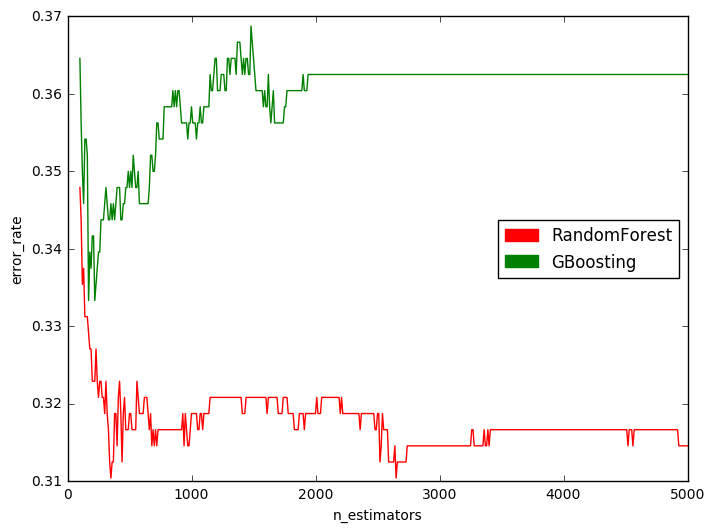

In [36]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X_train, X_test, y_train, y_test = train_test_split(data[:, :-1], data[:, -1], test_size=0.3, random_state=241)
r_error_rate = []
g_error_rate = []
r_clf = RandomForestClassifier(n_estimators=100, warm_start=True, n_jobs=-1)
g_clf = GradientBoostingClassifier(n_estimators=100, warm_start=True)
for n_est in range(100, 5001, 10):
    r_clf.set_params(**{'n_estimators': n_est})
    r_clf.fit(X_train, y_train)
    answer = r_clf.predict(X_test)
    r_error_rate.append(np.mean(answer != y_test))
    
    g_clf.set_params(**{'n_estimators': n_est})
    g_clf.fit(X_train, y_train)
    answer = g_clf.predict(X_test)
    g_error_rate.append(np.mean(answer != y_test))

plt.figure(figsize=(8, 6))
plt.plot(range(100, 5001, 10), r_error_rate, 'r')
plt.plot(range(100, 5001, 10), g_error_rate, 'g')
patches = []
patches.append(mpatches.Patch(color='r', label='RandomForest'))
patches.append(mpatches.Patch(color='g', label='GBoosting'))
plt.legend(handles=patches, loc=0)
plt.xlabel('n_estimators')
plt.ylabel('error_rate')
plt.show()

RandomForest выходит на асимптоту, в то время как GradientBoosting переобучается.

Здесь вы можете поделиться мыслями о задании.

А здесь — вставить нарисованную вами смешную картинку.